In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function for one-hot encoding
def encode_one_hot(labels):
    num_samples = labels.shape[0]
    num_classes = 10  # Assuming 10 classes (0-9)
    encoded = np.zeros((num_samples, num_classes), dtype=int)
    encoded[np.arange(num_samples), labels] = 1
    return encoded

# Function to read pixel data
def load_pixel_data(file_path):
    with open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
    return data.reshape(-1, 784).astype('float32') / 255.0

# Function to read label data
def load_label_data(file_path):
    with open(file_path, 'rb') as f:
        labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    return encode_one_hot(labels)

# Function to load MNIST dataset
def load_data(base_path):
    X_train = load_pixel_data(os.path.join(base_path, "train-images-idx3-ubyte"))
    y_train = load_label_data(os.path.join(base_path, "train-labels-idx1-ubyte"))
    X_test = load_pixel_data(os.path.join(base_path, "t10k-images-idx3-ubyte"))
    y_test = load_label_data(os.path.join(base_path, "t10k-labels-idx1-ubyte"))
    return X_train, y_train, X_test, y_test

class LogisticModel:
    def __init__(self, lr=5e-4, reg=1e-4, num_epochs=100, batch=200, input_size=784, num_classes=10, init_type='normal'):
        self.lr = lr
        self.reg = reg
        self.epochs = num_epochs
        self.batch_size = batch
        if init_type == 'normal':
            self.weights = np.random.normal(0, 1, (input_size, num_classes))  # N(0, 1)
        elif init_type == 'uniform':
            limit = np.sqrt(6 / (input_size + num_classes))
            self.weights = np.random.uniform(-limit, limit, (input_size, num_classes))
        elif init_type == 'zero':
            self.weights = np.zeros((input_size, num_classes))
        else:
            raise ValueError("Unsupported weight initialization type")
        self.biases = np.zeros((1, num_classes))

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Numerical stability
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def train(self, X_train, y_train, X_val, y_val):
        num_samples = X_train.shape[0]
        for epoch in range(self.epochs):
            indices = np.random.permutation(num_samples)
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, num_samples, self.batch_size):
                end = start + self.batch_size
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                # Forward pass
                logits = np.dot(X_batch, self.weights) + self.biases
                predictions = self.softmax(logits)

                # Gradients
                error = predictions - y_batch
                grad_weights = np.dot(X_batch.T, error) / self.batch_size + self.reg * self.weights
                grad_biases = np.sum(error, axis=0, keepdims=True) / self.batch_size

                # Update weights and biases
                self.weights -= self.lr * grad_weights
                self.biases -= self.lr * grad_biases

            val_accuracy, _ = self.evaluate(X_val, y_val)
            print(f"Epoch {epoch + 1}/{self.epochs}, Validation Accuracy: {val_accuracy:.4f}")

    def predict(self, X):
        logits = np.dot(X, self.weights) + self.biases
        return np.argmax(self.softmax(logits), axis=1)

    def evaluate(self, X, y_true):
        y_pred = self.predict(X)
        y_true_labels = np.argmax(y_true, axis=1)
        accuracy = np.mean(y_true_labels == y_pred)
        return accuracy, self.conf_matrix(y_true_labels, y_pred)

    @staticmethod
    def conf_matrix(y_true, y_pred):
        num_classes = np.max(y_true) + 1
        cm = np.zeros((num_classes, num_classes), dtype=int)
        for true_label, pred_label in zip(y_true, y_pred):
            cm[true_label, pred_label] += 1
        return cm

# Plot confusion matrix
def plot_matrix(matrix, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Experiment with batch sizes
def batch_size_experiment(X_train, y_train, X_val, y_val, params):
    batch_sizes = [1, 64, 3000]  # given values
    results = {}
    
    for batch in batch_sizes:
        print(f"\nBatch Size Experiment: {batch}")
        
        # Update the batch size in the params dictionary
        params_with_batch = {**params, 'batch': batch}
        model = LogisticModel(**params_with_batch)
        
        # Train the model and collect accuracies per epoch
        accuracies = []
        num_samples = X_train.shape[0]

        for epoch in range(params['num_epochs']):
            indices = np.random.permutation(num_samples)
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, num_samples, batch):
                end = start + batch
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                # Forward pass and backpropagation
                logits = np.dot(X_batch, model.weights) + model.biases
                predictions = model.softmax(logits)

                error = predictions - y_batch
                grad_weights = np.dot(X_batch.T, error) / batch + model.reg * model.weights
                grad_biases = np.sum(error, axis=0, keepdims=True) / batch

                # Update weights and biases
                model.weights -= model.lr * grad_weights
                model.biases -= model.lr * grad_biases

            # Evaluate on validation set after each epoch
            val_accuracy, _ = model.evaluate(X_val, y_val)
            accuracies.append(val_accuracy)
            print(f"Epoch {epoch + 1}/{params['num_epochs']}, Batch Size: {batch}, Validation Accuracy: {val_accuracy:.4f}")
        
        # Store the list of accuracies for the current batch size
        results[batch] = accuracies

    # Plot validation accuracy vs. epochs for all batch sizes
    plot_accuracies(results)


# Plot validation accuracies
def plot_accuracies(results):
    plt.figure(figsize=(10, 6))
    for key, values in results.items():
        plt.plot(range(1, len(values) + 1), values, label=key)
    plt.title("Validation Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# Weight Initialization Experiment
def weight_initialization_experiment(X_train, y_train, X_val, y_val, params):
    init_types = ['zero', 'uniform', 'normal']
    results = {}

    for init_type in init_types:
        print(f"\nWeight Initialization Experiment: {init_type.capitalize()}")
        params_with_init = {**params, 'init_type': init_type}
        model = LogisticModel(**params_with_init)
        accuracies = []

        for epoch in range(model.epochs):
            indices = np.random.permutation(X_train.shape[0])
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, X_train.shape[0], model.batch_size):
                end = start + model.batch_size
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                # Forward pass
                logits = np.dot(X_batch, model.weights) + model.biases
                predictions = model.softmax(logits)

                # Gradients
                error = predictions - y_batch
                grad_weights = np.dot(X_batch.T, error) / model.batch_size + model.reg * model.weights
                grad_biases = np.sum(error, axis=0, keepdims=True) / model.batch_size

                # Update weights and biases
                model.weights -= model.lr * grad_weights
                model.biases -= model.lr * grad_biases

            val_accuracy, _ = model.evaluate(X_val, y_val)
            accuracies.append(val_accuracy)
            print(f"Epoch {epoch + 1}/{model.epochs}, {init_type.capitalize()} Initialization, Validation Accuracy: {val_accuracy:.4f}")

        results[f"{init_type.capitalize()} Initialization"] = accuracies

    plot_accuracies(results)

def learning_rate_experiment(X_train, y_train, X_val, y_val, params):
    learning_rates = [0.01, 1e-3, 1e-4, 1e-5]  # Learning rates to experiment with
    results = {}

    for lr in learning_rates:
        print(f"\nLearning Rate Experiment: {lr}")
        params_with_lr = {**params, 'lr': lr}
        model = LogisticModel(**params_with_lr)
        accuracies = []

        for epoch in range(model.epochs):
            indices = np.random.permutation(X_train.shape[0])
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, X_train.shape[0], model.batch_size):
                end = start + model.batch_size
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                # Forward pass
                logits = np.dot(X_batch, model.weights) + model.biases
                predictions = model.softmax(logits)

                # Gradients
                error = predictions - y_batch
                grad_weights = np.dot(X_batch.T, error) / model.batch_size + model.reg * model.weights
                grad_biases = np.sum(error, axis=0, keepdims=True) / model.batch_size

                # Update weights and biases
                model.weights -= model.lr * grad_weights
                model.biases -= model.lr * grad_biases

            val_accuracy, _ = model.evaluate(X_val, y_val)
            accuracies.append(val_accuracy)
            print(f"Epoch {epoch + 1}/{model.epochs}, Learning Rate: {lr}, Validation Accuracy: {val_accuracy:.4f}")

        results[f"Learning Rate: {lr}"] = accuracies

    plot_accuracies(results)

def regularization_coefficient_experiment(X_train, y_train, X_val, y_val, params):
    reg_coeffs = [0.01, 1e-4, 1e-9]  # Regularization coefficients to experiment with
    results = {}

    for reg in reg_coeffs:
        print(f"\nRegularization Coefficient Experiment: {reg}")
        params_with_reg = {**params, 'reg': reg}
        model = LogisticModel(**params_with_reg)
        accuracies = []

        for epoch in range(model.epochs):
            indices = np.random.permutation(X_train.shape[0])
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, X_train.shape[0], model.batch_size):
                end = start + model.batch_size
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                # Forward pass
                logits = np.dot(X_batch, model.weights) + model.biases
                predictions = model.softmax(logits)

                # Gradients
                error = predictions - y_batch
                grad_weights = np.dot(X_batch.T, error) / model.batch_size + reg * model.weights
                grad_biases = np.sum(error, axis=0, keepdims=True) / model.batch_size

                # Update weights and biases
                model.weights -= model.lr * grad_weights
                model.biases -= model.lr * grad_biases

            val_accuracy, _ = model.evaluate(X_val, y_val)
            accuracies.append(val_accuracy)
            print(f"Epoch {epoch + 1}/{model.epochs}, Regularization Coefficient: {reg}, Validation Accuracy: {val_accuracy:.4f}")

        results[f"Regularization Coefficient: {reg}"] = accuracies

    plot_accuracies(results)

# Train the default model for Question 2.1
def train_default_model(X_train, y_train, X_test, y_test, params):
    print("Training the Default Model...")
    model = LogisticModel(**params)
    model.train(X_train, y_train, X_test, y_test)
    test_accuracy, cm = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    class_labels = [f"Class {i}" for i in range(10)]
    plot_matrix(cm, class_labels)

# Visualize weight vectors as images
def visualize_weights(weights, title="Weight Images"):
    """
    Visualizes the weight vectors as images.
    Each weight vector corresponds to one class (e.g., digits 0-9).
    """
    num_classes = weights.shape[1]  # Number of classes
    plt.figure(figsize=(10, 5))
    for i in range(num_classes):
        plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots for 10 classes
        plt.imshow(weights[:, i].reshape(28, 28), cmap="gray")  # Reshape weight vector to 28x28
        plt.title(f"Class {i}")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def calculate_metrics(confusion_matrix, num_classes=10):
    """
    Calculate precision, recall, F1 score, and F2 score for each class.
    :param confusion_matrix: Confusion matrix for predictions
    :param num_classes: Number of classes
    """
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)
    f2_score = np.zeros(num_classes)

    for i in range(num_classes):
        true_positive = confusion_matrix[i, i]
        false_positive = np.sum(confusion_matrix[:, i]) - true_positive
        false_negative = np.sum(confusion_matrix[i, :]) - true_positive

        # Precision: TP / (TP + FP)
        precision[i] = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0

        # Recall: TP / (TP + FN)
        recall[i] = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

        # F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
        f1_score[i] = (
            2 * precision[i] * recall[i] / (precision[i] + recall[i])
            if (precision[i] + recall[i]) > 0
            else 0
        )

        # F2 Score: (1 + 2^2) * (Precision * Recall) / (2^2 * Precision + Recall)
        f2_score[i] = (
            (1 + 2**2) * precision[i] * recall[i] / ((2**2 * precision[i]) + recall[i])
            if ((2**2 * precision[i]) + recall[i]) > 0
            else 0
        )

    return precision, recall, f1_score, f2_score


# Print the metrics for each class
def print_metrics(precision, recall, f1_score, f2_score):
    """
    Print precision, recall, F1 score, and F2 score for each class.
    """
    print("\nPrecision, Recall, F1 Score, and F2 Score for Each Class:")
    for i in range(len(precision)):
        print(
            f"Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1 Score={f1_score[i]:.4f}, F2 Score={f2_score[i]:.4f}"
        )


# Train the optimal model and calculate metrics
def train_optimal_model_with_metrics(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\nTraining the Optimal Model...")

    # Best hyperparameters determined from experiments
    best_params = {
        "lr": 1e-2,  # Best learning rate
        "reg": 1e-2,  # Best regularization coefficient
        "num_epochs": 100,
        "batch": 1,  # Best batch size
        "input_size": 784,
        "num_classes": 10,
        "init_type": "zero",  # Best weight initialization technique
    }

    # Train the optimal model
    model = LogisticModel(**best_params)
    model.train(X_train, y_train, X_val, y_val)

    # Evaluate on the test set
    test_accuracy, cm = model.evaluate(X_test, y_test)
    print(f"Optimal Model Test Accuracy: {test_accuracy:.4f}")

    # Plot confusion matrix for the optimal model
    class_labels = [f"Class {i}" for i in range(10)]
    plot_matrix(cm, class_labels)

    # Visualize the finalized weight vectors
    visualize_weights(model.weights, title="Finalized Weight Vectors as Images")

    # Calculate metrics
    precision, recall, f1_score, f2_score = calculate_metrics(cm)
    print_metrics(precision, recall, f1_score, f2_score)



dataset_path = "mnist"
X_train, y_train, X_test, y_test = load_data(dataset_path)
X_val, y_val = X_train[:10000], y_train[:10000]
X_train, y_train = X_train[10000:], y_train[10000:]

params = {
    'lr': 5e-4,
    'reg': 1e-4,
    'num_epochs': 100,
    'batch': 200,
    'input_size': 784,
    'num_classes': 10
}

Training the Default Model...
Epoch 1/100, Validation Accuracy: 0.1234
Epoch 2/100, Validation Accuracy: 0.1220
Epoch 3/100, Validation Accuracy: 0.1191
Epoch 4/100, Validation Accuracy: 0.1184
Epoch 5/100, Validation Accuracy: 0.1193
Epoch 6/100, Validation Accuracy: 0.1189
Epoch 7/100, Validation Accuracy: 0.1201
Epoch 8/100, Validation Accuracy: 0.1235
Epoch 9/100, Validation Accuracy: 0.1258
Epoch 10/100, Validation Accuracy: 0.1308
Epoch 11/100, Validation Accuracy: 0.1410
Epoch 12/100, Validation Accuracy: 0.1517
Epoch 13/100, Validation Accuracy: 0.1612
Epoch 14/100, Validation Accuracy: 0.1716
Epoch 15/100, Validation Accuracy: 0.1794
Epoch 16/100, Validation Accuracy: 0.1888
Epoch 17/100, Validation Accuracy: 0.1987
Epoch 18/100, Validation Accuracy: 0.2072
Epoch 19/100, Validation Accuracy: 0.2154
Epoch 20/100, Validation Accuracy: 0.2235
Epoch 21/100, Validation Accuracy: 0.2314
Epoch 22/100, Validation Accuracy: 0.2408
Epoch 23/100, Validation Accuracy: 0.2494
Epoch 24/100,

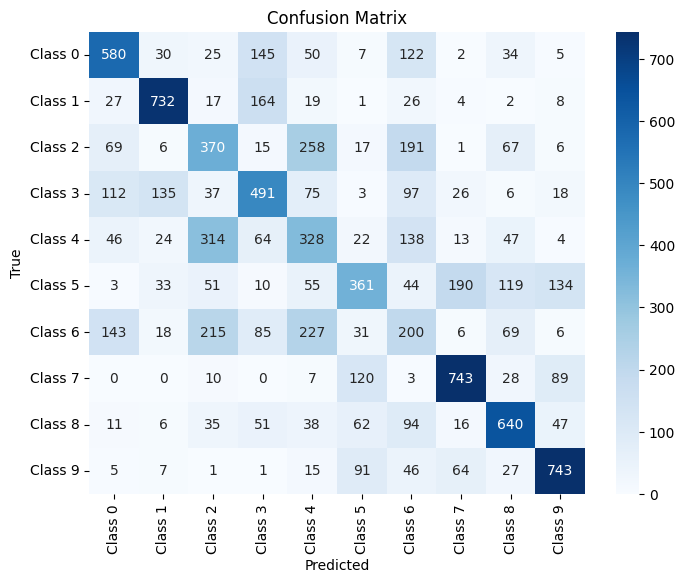

In [2]:
train_default_model(X_train, y_train, X_test, y_test, params)

In [3]:
batch_size_experiment(X_train, y_train, X_val, y_val, params)


Batch Size Experiment: 1
Epoch 1/100, Batch Size: 1, Validation Accuracy: 0.5949
Epoch 2/100, Batch Size: 1, Validation Accuracy: 0.6610
Epoch 3/100, Batch Size: 1, Validation Accuracy: 0.6934
Epoch 4/100, Batch Size: 1, Validation Accuracy: 0.7138
Epoch 5/100, Batch Size: 1, Validation Accuracy: 0.7243
Epoch 6/100, Batch Size: 1, Validation Accuracy: 0.7388
Epoch 7/100, Batch Size: 1, Validation Accuracy: 0.7449
Epoch 8/100, Batch Size: 1, Validation Accuracy: 0.7539
Epoch 9/100, Batch Size: 1, Validation Accuracy: 0.7603
Epoch 10/100, Batch Size: 1, Validation Accuracy: 0.7634
Epoch 11/100, Batch Size: 1, Validation Accuracy: 0.7698
Epoch 12/100, Batch Size: 1, Validation Accuracy: 0.7742
Epoch 13/100, Batch Size: 1, Validation Accuracy: 0.7795
Epoch 14/100, Batch Size: 1, Validation Accuracy: 0.7809
Epoch 15/100, Batch Size: 1, Validation Accuracy: 0.7845
Epoch 16/100, Batch Size: 1, Validation Accuracy: 0.7838
Epoch 17/100, Batch Size: 1, Validation Accuracy: 0.7863
Epoch 18/100, 

KeyboardInterrupt: 


Weight Initialization Experiment: Zero
Epoch 1/100, Zero Initialization, Validation Accuracy: 0.6113
Epoch 2/100, Zero Initialization, Validation Accuracy: 0.6469
Epoch 3/100, Zero Initialization, Validation Accuracy: 0.6606
Epoch 4/100, Zero Initialization, Validation Accuracy: 0.6621
Epoch 5/100, Zero Initialization, Validation Accuracy: 0.6632
Epoch 6/100, Zero Initialization, Validation Accuracy: 0.6629
Epoch 7/100, Zero Initialization, Validation Accuracy: 0.6645
Epoch 8/100, Zero Initialization, Validation Accuracy: 0.6668
Epoch 9/100, Zero Initialization, Validation Accuracy: 0.6673
Epoch 10/100, Zero Initialization, Validation Accuracy: 0.6679
Epoch 11/100, Zero Initialization, Validation Accuracy: 0.6701
Epoch 12/100, Zero Initialization, Validation Accuracy: 0.6714
Epoch 13/100, Zero Initialization, Validation Accuracy: 0.6755
Epoch 14/100, Zero Initialization, Validation Accuracy: 0.6787
Epoch 15/100, Zero Initialization, Validation Accuracy: 0.6813
Epoch 16/100, Zero Initi

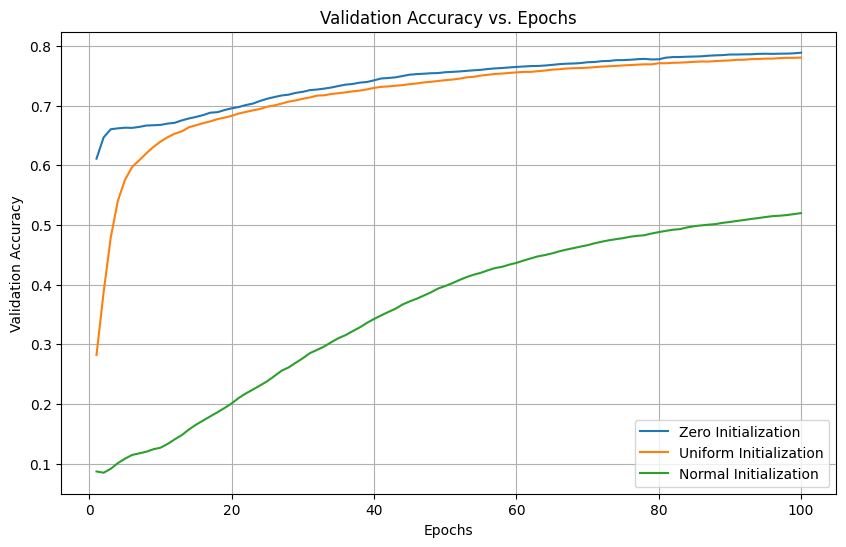

In [4]:
weight_initialization_experiment(X_train, y_train, X_val, y_val, params)


Learning Rate Experiment: 0.01
Epoch 1/100, Learning Rate: 0.01, Validation Accuracy: 0.2585
Epoch 2/100, Learning Rate: 0.01, Validation Accuracy: 0.3917
Epoch 3/100, Learning Rate: 0.01, Validation Accuracy: 0.4672
Epoch 4/100, Learning Rate: 0.01, Validation Accuracy: 0.5073
Epoch 5/100, Learning Rate: 0.01, Validation Accuracy: 0.5312
Epoch 6/100, Learning Rate: 0.01, Validation Accuracy: 0.5521
Epoch 7/100, Learning Rate: 0.01, Validation Accuracy: 0.5635
Epoch 8/100, Learning Rate: 0.01, Validation Accuracy: 0.5770
Epoch 9/100, Learning Rate: 0.01, Validation Accuracy: 0.5895
Epoch 10/100, Learning Rate: 0.01, Validation Accuracy: 0.5985
Epoch 11/100, Learning Rate: 0.01, Validation Accuracy: 0.6090
Epoch 12/100, Learning Rate: 0.01, Validation Accuracy: 0.6164
Epoch 13/100, Learning Rate: 0.01, Validation Accuracy: 0.6218
Epoch 14/100, Learning Rate: 0.01, Validation Accuracy: 0.6277
Epoch 15/100, Learning Rate: 0.01, Validation Accuracy: 0.6346
Epoch 16/100, Learning Rate: 0.0

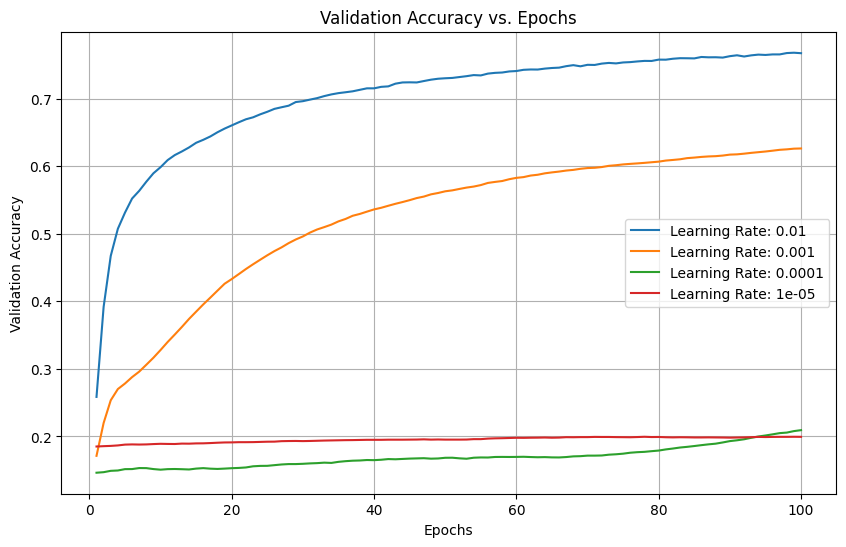

In [5]:
learning_rate_experiment(X_train, y_train, X_val, y_val, params)


Regularization Coefficient Experiment: 0.01
Epoch 1/100, Regularization Coefficient: 0.01, Validation Accuracy: 0.0908
Epoch 2/100, Regularization Coefficient: 0.01, Validation Accuracy: 0.1144
Epoch 3/100, Regularization Coefficient: 0.01, Validation Accuracy: 0.1295
Epoch 4/100, Regularization Coefficient: 0.01, Validation Accuracy: 0.1422
Epoch 5/100, Regularization Coefficient: 0.01, Validation Accuracy: 0.1573
Epoch 6/100, Regularization Coefficient: 0.01, Validation Accuracy: 0.1731
Epoch 7/100, Regularization Coefficient: 0.01, Validation Accuracy: 0.1841
Epoch 8/100, Regularization Coefficient: 0.01, Validation Accuracy: 0.1943
Epoch 9/100, Regularization Coefficient: 0.01, Validation Accuracy: 0.2017
Epoch 10/100, Regularization Coefficient: 0.01, Validation Accuracy: 0.2076
Epoch 11/100, Regularization Coefficient: 0.01, Validation Accuracy: 0.2093
Epoch 12/100, Regularization Coefficient: 0.01, Validation Accuracy: 0.2111
Epoch 13/100, Regularization Coefficient: 0.01, Vali

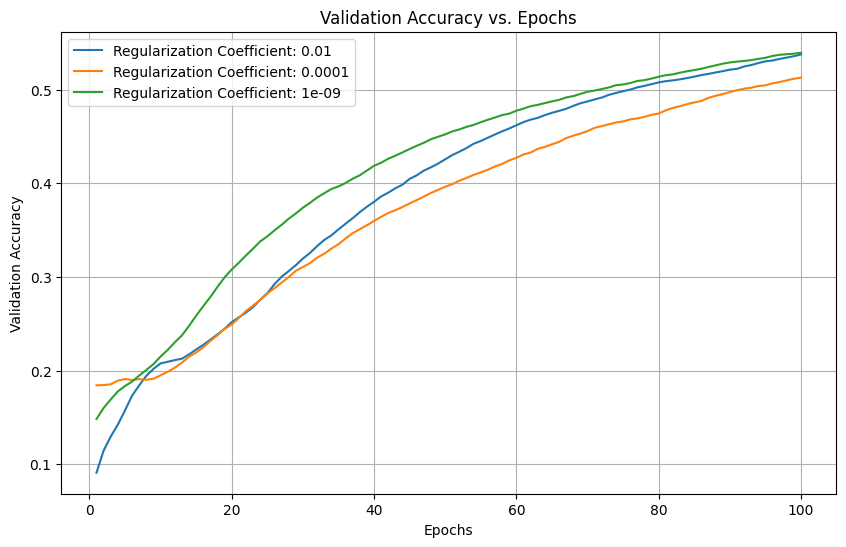

In [6]:
regularization_coefficient_experiment(X_train, y_train, X_val, y_val, params)


Training the Optimal Model...
Epoch 1/100, Validation Accuracy: 0.7883
Epoch 2/100, Validation Accuracy: 0.7885
Epoch 3/100, Validation Accuracy: 0.7689
Epoch 4/100, Validation Accuracy: 0.7959
Epoch 5/100, Validation Accuracy: 0.7864
Epoch 6/100, Validation Accuracy: 0.7612
Epoch 7/100, Validation Accuracy: 0.8105
Epoch 8/100, Validation Accuracy: 0.8145
Epoch 9/100, Validation Accuracy: 0.7930
Epoch 10/100, Validation Accuracy: 0.8040
Epoch 11/100, Validation Accuracy: 0.8052
Epoch 12/100, Validation Accuracy: 0.7384
Epoch 13/100, Validation Accuracy: 0.7604
Epoch 14/100, Validation Accuracy: 0.7292
Epoch 15/100, Validation Accuracy: 0.7740
Epoch 16/100, Validation Accuracy: 0.8005
Epoch 17/100, Validation Accuracy: 0.7983
Epoch 18/100, Validation Accuracy: 0.7593
Epoch 19/100, Validation Accuracy: 0.8147
Epoch 20/100, Validation Accuracy: 0.7562
Epoch 21/100, Validation Accuracy: 0.8056
Epoch 22/100, Validation Accuracy: 0.8079
Epoch 23/100, Validation Accuracy: 0.7979
Epoch 24/100

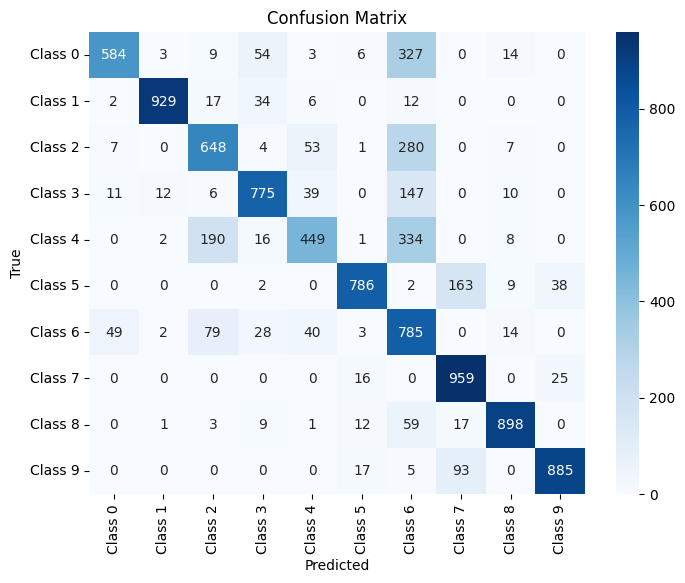

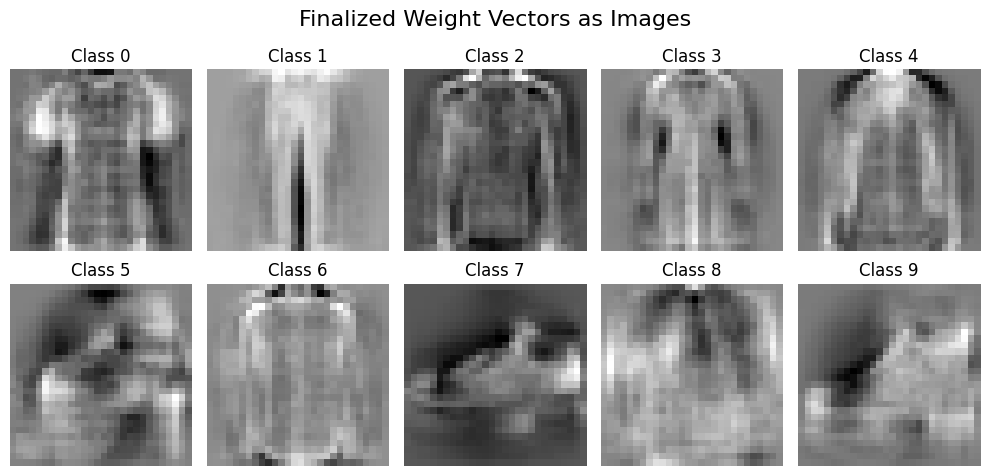


Precision, Recall, F1 Score, and F2 Score for Each Class:
Class 0: Precision=0.8943, Recall=0.5840, F1 Score=0.7066, F2 Score=0.6276
Class 1: Precision=0.9789, Recall=0.9290, F1 Score=0.9533, F2 Score=0.9386
Class 2: Precision=0.6807, Recall=0.6480, F1 Score=0.6639, F2 Score=0.6543
Class 3: Precision=0.8406, Recall=0.7750, F1 Score=0.8065, F2 Score=0.7873
Class 4: Precision=0.7597, Recall=0.4490, F1 Score=0.5644, F2 Score=0.4890
Class 5: Precision=0.9335, Recall=0.7860, F1 Score=0.8534, F2 Score=0.8116
Class 6: Precision=0.4024, Recall=0.7850, F1 Score=0.5320, F2 Score=0.6596
Class 7: Precision=0.7784, Recall=0.9590, F1 Score=0.8593, F2 Score=0.9165
Class 8: Precision=0.9354, Recall=0.8980, F1 Score=0.9163, F2 Score=0.9052
Class 9: Precision=0.9335, Recall=0.8850, F1 Score=0.9086, F2 Score=0.8943


In [7]:
train_optimal_model_with_metrics(X_train, y_train, X_val, y_val, X_test, y_test)